In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-04 22:23:19.608104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 22:23:19.990389: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 22:23:21.112972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_066
rm: cannot remove '/kaggle/output/exp_066': No such file or directory


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes
0,4995,5039.0,5051.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5
1,10928,10895.0,10907.5,038441c925bb,0.754868,wakeup,33.655094,37.0,2337.5
2,20288,20375.0,20387.5,038441c925bb,0.630360,onset,-86.351067,-131.0,2937.5
3,27432,27455.0,27467.5,038441c925bb,0.880441,wakeup,-22.161205,37.0,2337.5
4,39989,40007.0,40019.5,038441c925bb,0.879920,onset,-17.894793,-11.0,297.5


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [3]:
# 周辺に予測を撒く
dfs = []
for level, diff in enumerate([0, -1, 1, -2, 2, -3, 3, -5, 5, -10, 10, -15, 15, -30, 30]):
    tmp = sub.copy()
    tmp["level"] = level
    tmp["step"] += CFG["feature"]["agg_freq"] * diff
    tmp["key_step"] += CFG["feature"]["agg_freq"] * diff
    tmp["sub_step_before_modify"] += CFG["feature"]["agg_freq"] * diff
    dfs.append(tmp)
sub = pd.concat(dfs, axis=0).reset_index(drop=True)
sub.sort_values(["series_id", "step", "level"], inplace=True)
sub = sub.drop_duplicates(["series_id", "step"], keep="first").reset_index(drop=True)
sub.head()

,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4275,4319.0,4331.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,13
1,4635,4679.0,4691.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,11
2,4755,4799.0,4811.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,9
3,4875,4919.0,4931.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,7
4,4923,4967.0,4979.5,038441c925bb,0.834676,onset,-43.046986,-47.0,1857.5,5


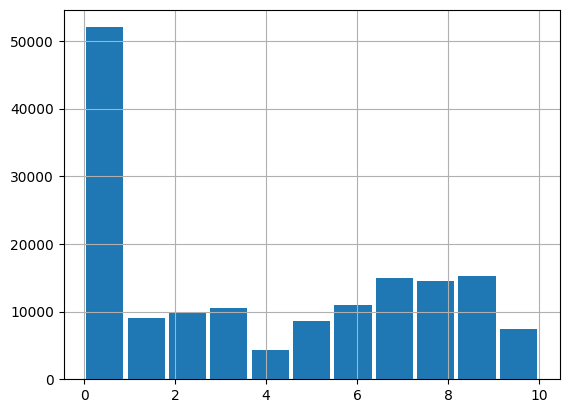

series_id                 5331720
step                      5331720
oof_stage2                5331720
minutes                    878147
target                     157495
sub_step                   157495
key_step                   157495
sub_step_before_modify     157495
event                      157495
level                      157495
score                      157357
oof_regressor              157495
dtype: int64
5.322633703106539


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        for step in label_df["step"].values:
            for idx, sub_step in enumerate(sub_df["step"].values):
                dist = abs(step - sub_step)
                if dist < thresh:
                    targets[idx] += 1
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [6]:
# # スコアの理論値(targetを完璧に当てれた場合)
# ideal_sub = sub.copy()
# ideal_sub["score"] = ideal_sub["target"]
# ideal_sub["step"] = ideal_sub["sub_step"]

# labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
# score, ap_table = compute_comptetition_metric(labels, ideal_sub)
# print(f"score: {score:.4f}")
# display(ap_table)

In [7]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.9307250912884716


event   threshold
onset   12           0.773742
        36           0.885410
        60           0.925068
        90           0.931330
        120          0.939470
        150          0.946149
        180          0.954289
        240          0.957003
        300          0.959716
        360          0.964517
wakeup  12           0.762203
        36           0.902169
        60           0.947434
        90           0.953275
        120          0.958073
        150          0.964748
        180          0.969962
        240          0.971423
        300          0.973509
        360          0.974969
Name: target, dtype: float64

In [8]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:24<00:00,  1.36it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4275.0,4331.5,4319.0,onset,13.0,...,0.0,0.960272,-0.002529,0.742022,0.0,0.998246,-0.000057,0.929244,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,1.0,4635.0,4691.5,4679.0,onset,11.0,...,0.0,0.959926,-0.003268,0.724258,0.0,0.998064,-0.000062,0.922430,0.0,2
2,038441c925bb,4811.5,0.993161,657.5,3.0,4755.0,4811.5,4799.0,onset,9.0,...,0.0,0.958227,-0.003156,0.717534,0.0,0.997701,-0.000078,0.918442,0.0,2
3,038441c925bb,4931.5,0.978979,1257.5,6.0,4875.0,4931.5,4919.0,onset,7.0,...,0.0,0.956779,-0.003403,0.710106,0.0,0.997368,-0.000110,0.908672,0.0,2
4,038441c925bb,4979.5,0.655212,1497.5,7.0,4923.0,4979.5,4967.0,onset,5.0,...,0.0,0.955628,-0.003881,0.709399,0.0,0.997191,-0.000128,0.904474,0.0,2


(157495, 1390)

In [9]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:4.96265
[100]	eval-rmse:2.64572
[200]	eval-rmse:2.13918
[300]	eval-rmse:2.05630
[400]	eval-rmse:2.04304
[500]	eval-rmse:2.04088
[561]	eval-rmse:2.04107


 20%|██        | 1/5 [00:20<01:22, 20.57s/it]

== fold 1 ==
[0]	eval-rmse:4.96018
[100]	eval-rmse:2.65863
[200]	eval-rmse:2.12603
[300]	eval-rmse:2.02469
[400]	eval-rmse:2.00268
[500]	eval-rmse:1.99730
[600]	eval-rmse:1.99472
[700]	eval-rmse:1.99469
[800]	eval-rmse:1.99397
[900]	eval-rmse:1.99356
[1000]	eval-rmse:1.99361
[1054]	eval-rmse:1.99408


 40%|████      | 2/5 [00:54<01:24, 28.17s/it]

== fold 2 ==
[0]	eval-rmse:4.91965
[100]	eval-rmse:2.65606
[200]	eval-rmse:2.15068
[300]	eval-rmse:2.05915
[400]	eval-rmse:2.04009
[500]	eval-rmse:2.03423
[600]	eval-rmse:2.03121
[700]	eval-rmse:2.03077
[800]	eval-rmse:2.03007
[900]	eval-rmse:2.02991
[1000]	eval-rmse:2.02969
[1100]	eval-rmse:2.02951
[1180]	eval-rmse:2.02980


 60%|██████    | 3/5 [01:29<01:03, 31.64s/it]

== fold 3 ==
[0]	eval-rmse:4.93339
[100]	eval-rmse:2.63379
[200]	eval-rmse:2.14674
[300]	eval-rmse:2.07955
[400]	eval-rmse:2.07496
[451]	eval-rmse:2.07685


 80%|████████  | 4/5 [01:46<00:25, 25.72s/it]

== fold 4 ==
[0]	eval-rmse:4.85363
[100]	eval-rmse:2.62156
[200]	eval-rmse:2.17737
[300]	eval-rmse:2.12319
[400]	eval-rmse:2.12188
[456]	eval-rmse:2.12454


100%|██████████| 5/5 [02:03<00:00, 24.61s/it]


In [10]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.3552


event   tolerance
onset   12           0.206407
        36           0.323996
        60           0.349926
        90           0.361336
        120          0.367756
        150          0.372370
        180          0.375311
        240          0.378727
        300          0.381329
        360          0.383620
wakeup  12           0.209980
        36           0.335617
        60           0.361308
        90           0.372529
        120          0.378023
        150          0.382445
        180          0.385325
        240          0.389293
        300          0.393197
        360          0.395388
dtype: float64